# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi_Mbb/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.8
euler_1, euler_2, euler_3 = 40*u.deg, 50*u.deg, 15*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = int(np.random.uniform(0,10000000)) #25253

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: (3e-9 + 9e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = None #24355

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 10
scale_bins = 'lin'
kmin_pk = 1/(60*4)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = True

# MCMC
nwalkers = 20
nsteps = 500
burnin = 200
mcmc_reset = True
mcmc_run = True
mcmc_Nresamp = 100

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [6, 6]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*5

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 73 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   2295.2   ,   2295.2   ] kpc ; [   6.083    ,   6.083    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000436  /  0.015685   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.noise_covmat = data.get_noise_covariance_from_model(Nmc=1000)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


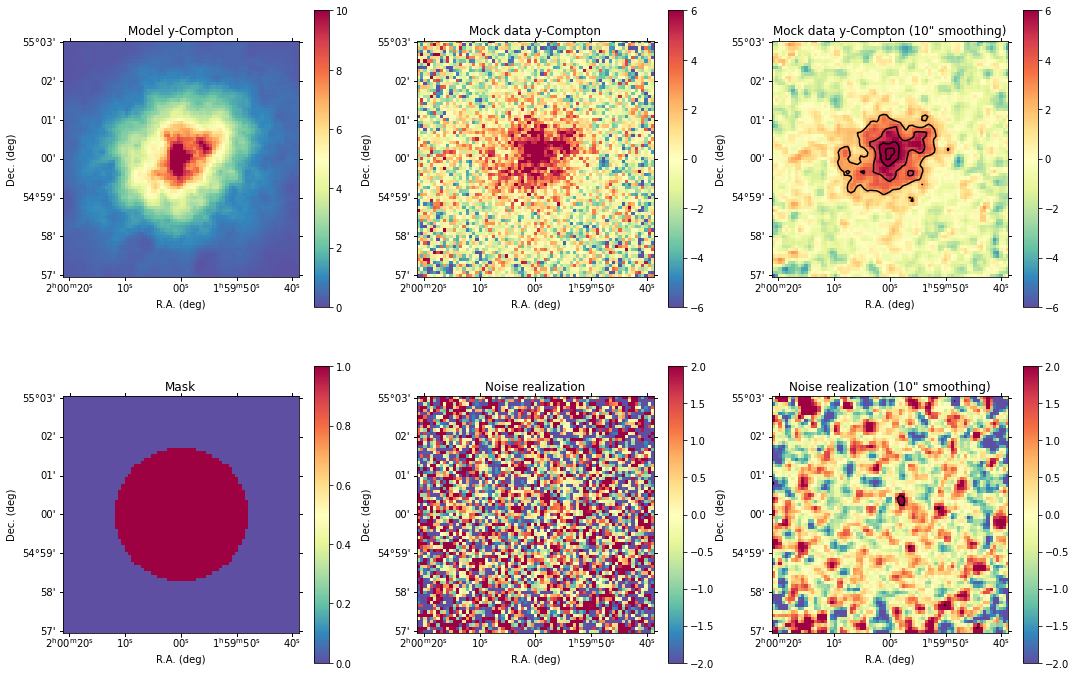

In [8]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Build model to be used in the fit

In [10]:
model = copy.deepcopy(mock)

In [11]:
inference = pitszi.Inference(data, model, output_dir=output_dir)

inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

inference.mcmc_nwalkers = nwalkers
inference.mcmc_nsteps   = nsteps
inference.mcmc_burnin   = burnin
inference.mcmc_reset    = mcmc_reset
inference.mcmc_run      = mcmc_run
inference.mcmc_Nresamp  = mcmc_Nresamp

inference.method_use_covmat  = method_use_covmat
inference.method_parallel    = method_parallel
inference.method_data_deconv = method_data_deconv
inference.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)
if os.path.exists(inference.output_dir+'/inference_parameters.pkl') and method_setup_overwrite == False:
    inference.load_inference(inference.output_dir+'/inference_parameters.pkl')
else:
    inference.setup()
    inference.save_inference()

----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 16.  16.  32.  44.  64.  56.  60.  92.  96. 112.]
      - Minimal count in k bins: 16.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


### Check that inference can extract data, model and noise properties to be passed to fitting tools

##### Case of the radial model

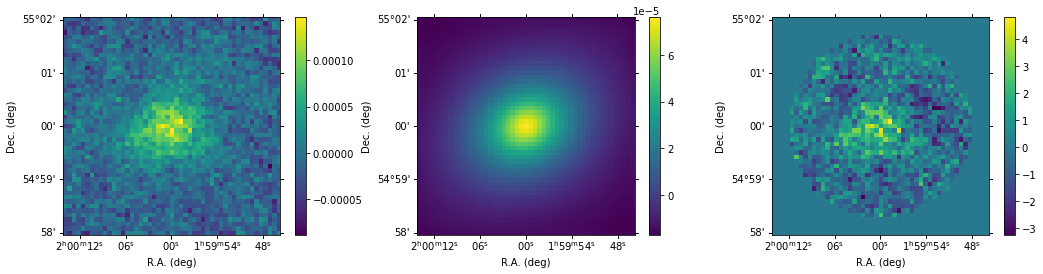

In [12]:
#inference.nuisance_ZL = 0
#inference.model.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
#                               'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
#inference.model.model_pressure_profile['P_0'] *= 1

resid = (inference.get_radial_data() - inference.get_radial_model()) / inference.get_radial_noise_statistics()[0]

plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 4))

ax = plt.subplot(1, 3, 1, projection=WCS(data.header))
plt.imshow(inference.get_radial_data())
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(data.header))
plt.imshow(inference.get_radial_model())
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 3, projection=WCS(data.header))
plt.imshow(resid*inference.data.mask)
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

##### Case of Pk

In [13]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True

In [14]:
k2d, pk2d_data = inference.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = inference.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = inference.get_pk2d_model_statistics(physical=phys, Nmc=100)

In [15]:
k2d, pk2d_test_modbrute = inference.get_pk2d_model_brute(physical=phys, seed=1)
k2d, pk2d_test_moddeproj = inference.get_pk2d_model_proj(physical=phys)

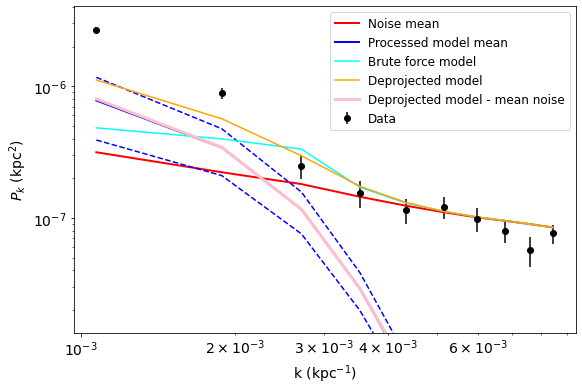

In [16]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             np.diag(pk2d_noisecovmat.to_value(unit+'4'))**0.5, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), pk2d_noise.to_value(unit+'2'), color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2'), color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') + np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') - np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_test_moddeproj-pk2d_noise).to_value(unit+'2'), color='pink', lw=3, label='Deprojected model - mean noise')
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

##### Computing time

In [17]:
start = time.time()
inference.get_radial_model()
end = time.time()
print('Computing time, radial model (s):', end - start)

start = time.time()
inference.get_pk2d_model_brute()
end = time.time()
print('Computing time, fluctuation brute (s):', end - start)

start = time.time()
inference.get_pk2d_model_proj()
end = time.time()
print('Computing time, fluctuation projection (s):', end - start)

Computing time, radial model (s): 0.024754762649536133
Computing time, fluctuation brute (s): 0.08453702926635742
Computing time, fluctuation projection (s): 0.0611569881439209


### Fitting for the profile

In [18]:
fitpar = {
    'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
    'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
    'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
    #'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
    #'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
    #'RA': {'guess':[RA.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-1, RA.to_value('arcmin')+1]},
    #'Dec': {'guess':[Dec.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-1, Dec.to_value('arcmin')+1]},
    'ZL':{'guess':[0,1e-5],'unit':None},
              }

In [19]:
parlist, sampler = inference.fit_profile_mcmc(fitpar, show_fit_result=True)

----- No existing sampler found
----- Fit parameters information -----
      - Fitted parameters:            
['P_0' 'r_p' 'a' 'b' 'c' 'ZL']
      - Starting point mean:          
[2.e-02 1.e+03 1.e+00 5.e+00 5.e-01 0.e+00]
      - Starting point dispersion :   
[1.e-03 1.e+03 5.e-01 5.e-01 5.e-01 1.e-05]
      - Minimal starting point:       
[  0.   0.   0.   0.  -1. -inf]
      - Maximal starting point:       
[inf inf 10. 10.  3. inf]
      - Number of dimensions:         
6
      - Parallel mode:                
False
      - Use covariance matrix?        
False
-----
----- Does the sampler already exist? -----
      - No, start from scratch
----- MCMC sampling -----
      - Runing 1000 MCMC steps


100%|██████████| 1000/1000 [05:59<00:00,  2.78it/s]


param 0 (P_0): 
   median   = 0.04494502501941258 -0.012269634874232715 +0.012351967500389804
   best-fit = 0.06510910996250337 -0.0324337198173235 +-0.00781211744270098
   P_0 = 0.04494502501941258_{-0.012269634874232715}^{0.012351967500389804}
param 1 (r_p): 
   median   = 673.6404965764973 -129.52609854766456 +202.76022590572893
   best-fit = 402.22551327928363 --141.8888847495491 +474.1752092029426
   r_p = 673.6404965764973_{-129.52609854766456}^{202.76022590572893}
param 2 (a): 
   median   = 1.9279398560852399 -0.30497318690415587 +0.20139428628642575
   best-fit = 2.170452889893733 -0.547486220712649 +-0.041118747522067345
   a = 1.9279398560852399_{-0.30497318690415587}^{0.20139428628642575}
param 3 (b): 
   median   = 8.335186999637717 -2.02434476640114 +1.1921328817163275
   best-fit = 4.689438766885902 --1.6214034663506744 +4.837881114468142
   b = 8.335186999637717_{-2.02434476640114}^{1.1921328817163275}
param 4 (c): 
   median   = 0.41852651008895125 -0.11406352712208057

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [21]:
~2.6 it /s: single 
~14.0 s/it: multiproc

SyntaxError: invalid syntax (<ipython-input-21-9b3fe0bac0d4>, line 1)

In [ ]:
mock.model_pressure_profile, RA.to_value('arcmin'), Dec.to_value('arcmin')

In [ ]:
from pathos.multiprocessing import ProcessPool
pool = ProcessPool()
pool

In [ ]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    #'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],               
              }
fitpar_noise = {'ampli':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]}}

In [ ]:
inference.test_mcmc(fitpar_pk3d)
#pitszi.inference_main.test_mcmc(inference, fitpar_pk3d)

In [ ]:
100 walkers, pathos para, out --> 1.64 s/it
100 walkers, std para, out    --> 1.64 s/it
100 walkers, 0 para, out      --> 10.32 s/it


100 walkers, pathos para, in --> 1.64
100 walkers, std para, in    --> 1.63
100 walkers, 0 para, in      --> 10.33

100 walkers, pathos para, with self --> 1.70 s/it
100 walkers, std para, with self    --> fail
100 walkers, 0 para, with self      --> 10.29

100 walkers, pathos para, with self and lnlike self --> 1.69 s/it
100 walkers, std para, with self and lnlike self    --> fail
100 walkers, 0 para, with self  and lnlike self     --> 10.29

In [ ]:
img, _, _ = inference.get_image_data()
plt.imshow(img)
plt.colorbar()

In [ ]:
from scipy.optimize import curve_fit

k_mod, pk_mod, pk_mod_cov = inference.get_pk2d_modelvar_statistics(Nmc=100)
k_noi, pk_noi, pk_noi_cov = inference.get_pk2d_noise_statistics(Nmc=100)
k_dat, pk_dat = inference.get_pk2d_data()

def fitfunc(x, par1, par2, par3):
    inference.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                                  'Norm': fluct_norm*par1, 
                                                  'slope': fluct_slope,
                                                  'Linj': fluct_linj*par2,
                                                  'Ldis': 1*u.kpc}
    k_test, pk_test = inference.modelpred_fluct_deproj_forward(physical=False)
    return pk_test.to_value('arcsec2') + par3*pk_noi.to_value('arcsec2')

popt, pcov = curve_fit(fitfunc, 0, pk_dat.to_value('arcsec2'),
                       p0=[1,1,1], sigma=(np.diag(pk_noi_cov)**0.5).to_value('arcsec2'))

In [ ]:
print(popt)
print(np.diag(pcov)**0.5)
print(pitszi.utils.correlation_from_covariance(pcov))
inference.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                              'Norm': fluct_norm*popt[0], 
                                              'slope': fluct_slope,
                                              'Linj': fluct_linj*popt[1],
                                              'Ldis': 1*u.kpc}
k_best, pk_best = inference.modelpred_fluct_deproj_forward(physical=False)

plt.errorbar(k_dat.value, pk_dat.value, np.diag(pk_noi_cov.value)**0.5)
plt.loglog(k_best, pk_best + popt[2]*pk_noi)
plt.loglog(k_best, pk_best)
plt.loglog(k_best, popt[2]*pk_noi)
plt.ylim(np.amax(pk_dat.value+np.diag(pk_noi_cov.value)**0.5)*1e-2, 
         np.amax(pk_dat.value+np.diag(pk_noi_cov.value)**0.5)*1.5)

# Fit the fluctuation parameters: deprojection

In [ ]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    #'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],               
              }
fitpar_noise = {'ampli':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]}}

In [ ]:
fitpar, sampler = inference.fit_fluct_deproj_forward(fitpar_pk3d,
                                                     parinfo_noise=fitpar_noise, 
                                                     Nmc_noise=100,
                                                     use_covmat=False)

In [ ]:
inference.get_mcmc_chains_outputs_results(fitpar, sampler, extraname='_Pk_deproj')

In [ ]:
in

# Fit the fluctuation parameters: brute force